# GOSTnets with overture
The [Overture Maps Foundation](https://overturemaps.org/) publishes an interesting data product that merges OpenStreetMap with several additional datasets that are not included in OSM. 

This notebook walks through how to extract Overture data (both roads and destinations) and use them in a GOSTnets analysis. All of these individual steps are included in the Step_* notebooks

In [40]:
import os, sys, json
import overturemaps

import pandas as pd
import geopandas as gpd
import ipywidgets as widgets
import networkx as nx

sys.path.insert(0, r"C:\WBG\Work\Code\GOSTnets\src")
import GOSTnets as gn
import GOSTnets.conversion_utils as cu

from ipyleaflet import Map, DrawControl
from shapely.geometry import shape


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Center the map in your region of interest
m = Map(center=(4.0, 33.0), zoom=6)

draw_control = DrawControl(
    polygon = {
        "shapeOptions": {
            "color": "#6e6d6b",
            "weight": 2,
            "fillOpacity": 0.5
        },
        "drawError": {
            "color": "#dd253b",
            "message": "Error drawing shape!"
        },
    },
    rectangle = {
        "shapeOptions": {
            "color": "#6e6d6b",
            "weight": 2,
            "fillOpacity": 0.5
        }
    },
    circlemarker={},
    polyline={},
    marker={}
)

user_aoi = None

def handle_draw(self, action, geo_json):
    global user_aoi
    user_aoi = geo_json
    print("AOI captured:")
    print(json.dumps(user_aoi, indent=2))
    
    # Convert to a shapely geometry
    geom = shape(geo_json['geometry'])
    print("Area (approx.):", geom.area, "square degrees")

draw_control.on_draw(handle_draw)
m.add_control(draw_control)

m

Map(center=[4.0, 33.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

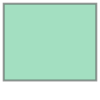

In [9]:
aoi_geojson = {
    "type": "Feature",
    "geometry": user_aoi['geometry'],
    "properties": {"name": "User Selected AOI"}
}
shape(aoi_geojson)

Overture data are stored as open parquet files on AWS, you can find more details on accessing those files directly [here](https://docs.overturemaps.org/getting-data/). For this notebook, we rely on the OvertureMaps python library, specifically the __overturemaps.record_batch_reader__ function.

__Note on release parameter:__ The release parameter is not absolutely necessary, as the library has a method to determine the most recent release (in a fairly elegant way, I may add). However, searching for the most recent release number can cause SSL errors (from the STAC implementation), so providing a specific release number eliminates that problem. Details on the release calendar [can be found here](https://docs.overturemaps.org/release-calendar/)


In [ ]:
# Downlaod data from Overture
# The overture maps transport network extraction requires a bounding box in WGS84 (EPSG:4326) format
bbox = shape(aoi_geojson).bounds
# Extract the transport network within the bounding box
transport = overturemaps.record_batch_reader("segment", bbox, release="2025-12-17.0").read_all()
transport_df = gpd.GeoDataFrame.from_arrow(transport)
transport_df.crs = 4326
transport_df = transport_df.loc[:, ["id", "class", "subtype", "road_surface", "speed_limits", "width_rules", "geometry"]]

transport_df.head()

,id,class,subtype,road_surface,speed_limits,width_rules,geometry
0,88379c65-afd4-45ac-8036-e17c6bfa02d5,unclassified,road,"[{'value': 'unpaved', 'between': None}]",None,None,"LINESTRING (31.39037 4.90711, 31.39141 4.90747..."
1,b7d7e1f2-644b-4e79-b171-bb9d6d1fe863,unclassified,road,"[{'value': 'unpaved', 'between': None}]",None,None,"LINESTRING (31.5802 4.94815, 31.58012 4.94814,..."
2,005058fa-3719-4597-aa52-4ebb685bb4c5,track,road,"[{'value': 'unpaved', 'between': None}]",None,None,"LINESTRING (31.50077 4.94116, 31.50082 4.94132..."
3,6f925752-93a8-4330-81d2-afcf882383e9,path,road,None,None,None,"LINESTRING (31.51803 4.94658, 31.51814 4.94656..."
4,c82aad54-29b0-4f9b-b18b-c237e539bb5a,track,road,"[{'value': 'unpaved', 'between': None}]",None,None,"LINESTRING (31.50994 4.95408, 31.50999 4.95391..."


In [12]:
G = cu.convert_roads_to_nx(transport_df, unq_id='id', infra_field='class')

Processing 0 of 35349
seconds elapsed: 0.0035796165466308594
Processing 1000 of 35349
seconds elapsed: 0.9707839488983154
Processing 2000 of 35349
seconds elapsed: 1.92580246925354
Processing 3000 of 35349
seconds elapsed: 2.911710500717163
Processing 4000 of 35349
seconds elapsed: 3.9490156173706055
Processing 5000 of 35349
seconds elapsed: 5.040392875671387
Processing 6000 of 35349
seconds elapsed: 6.095744609832764
Processing 7000 of 35349
seconds elapsed: 7.091665506362915
Processing 8000 of 35349
seconds elapsed: 8.070157766342163
Processing 9000 of 35349
seconds elapsed: 9.10720443725586
Processing 10000 of 35349
seconds elapsed: 10.166046380996704
Processing 11000 of 35349
seconds elapsed: 11.165176391601562
Processing 12000 of 35349
seconds elapsed: 12.224538087844849
Processing 13000 of 35349
seconds elapsed: 13.260303735733032
Processing 14000 of 35349
seconds elapsed: 14.363865852355957
Processing 15000 of 35349
seconds elapsed: 15.34241533279419
Processing 16000 of 35349
se

In [ ]:
# Clean the road network
### In order to properly clean the network, we need to define an appropriate metres-based projection
### We have defined a default as 3857 (Web Mercator), but for better accuracy we recommend using a UTM zone appropriate for your AOI
sel_wgs = 3857

G_clean = gn.clean_network(
    G, UTM=sel_wgs, WGS=4326, junctdist=10, verbose=False
)

# Identify only the largest graph
list_of_subgraphs = list(
    G_clean.subgraph(c).copy() for c in nx.strongly_connected_components(G_clean)
)
max_graph = None
max_edges = 0
for i in list_of_subgraphs:
    if i.number_of_edges() > max_edges:
        max_edges = i.number_of_edges()
        max_graph = i

# set your graph equal to the largest sub-graph
G_largest = max_graph

C:\WBG\Work\Code\GOSTnets\src\GOSTnets\core.py:2147: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  juncs_gdf_unproj["centroid"] = juncs_gdf_unproj.centroid


39488
completed processing 78976 edges
38742
completed processing 77484 edges
Edge reduction: 39488 to 77484 (-96 percent)


In [37]:
# Convert the road network class and length to travel time in seconds
G_largest = gn.convert_network_to_time(
    G_largest, distance_tag="length", road_col="infra_type", factor=1000
)

# Destinations

In [ ]:
# Downlaod destinatons from Overture
poi = overturemaps.record_batch_reader("place", bbox, release="2025-12-17.0").read_all()
poi = gpd.GeoDataFrame.from_arrow(transport)
poi.crs = 4326
poi.head()

,id,geometry,bbox,version,sources,names,categories,basic_category,taxonomy,confidence,websites,socials,emails,phones,brand,addresses,operating_status
0,e9387508-a9bc-42ce-b7d6-88690cbe3dc8,POINT (31.5904 4.93018),"{'xmin': 31.59039878845215, 'xmax': 31.5904026...",4,"[{'property': '', 'dataset': 'meta', 'license'...","{'primary': 'Union Medical', 'common': None, '...","{'primary': 'pharmaceutical_companies', 'alter...",b2b_service,"{'primary': 'pharmaceutical_companies', 'hiera...",0.323479,[http://Www.unionholding.net/],[https://www.facebook.com/104086821281112],None,[+211912300950],None,"[{'freeform': 'Airport Rd., Juba, South Sudan'...",open
1,027995e4-db40-404e-8a45-d502893e5310,POINT (31.64062 4.79542),"{'xmin': 31.640625, 'xmax': 31.640625, 'ymin':...",4,"[{'property': '', 'dataset': 'meta', 'license'...",{'primary': 'Alliance Law Chambers - South Sud...,"{'primary': 'lawyer', 'alternate': None}",attorney_or_law_firm,"{'primary': 'lawyer', 'hierarchy': ['services_...",0.639236,[http://www.alliance-lawchambers.com/],[https://www.facebook.com/114696996938684],None,[+211924379807],None,"[{'freeform': 'Mahata Yei, opp. Snit Building ...",open
2,e1cbbc8d-cbf4-4f07-a6fe-e105e9ff9872,POINT (31.64561 4.82792),"{'xmin': 31.645612716674805, 'xmax': 31.645616...",4,"[{'property': '', 'dataset': 'meta', 'license'...","{'primary': 'Juba Highway Hotel', 'common': No...","{'primary': 'hotel', 'alternate': None}",hotel,"{'primary': 'hotel', 'hierarchy': ['lodging', ...",0.639236,[https://maps.app.goo.gl/Z8cpyo4o8VRm46C67],[https://www.facebook.com/109908188585111],None,[+211980888872],None,"[{'freeform': 'Mapaw\n', 'locality': 'Juba', '...",open
3,a1259455-ac98-46e4-888a-c3e05887437a,POINT (31.62415 4.91652),"{'xmin': 31.624141693115234, 'xmax': 31.624145...",5,"[{'property': '', 'dataset': 'meta', 'license'...",{'primary': 'Sirikundu Na Mihimitire Global Le...,"{'primary': 'lawyer', 'alternate': None}",attorney_or_law_firm,"{'primary': 'lawyer', 'hierarchy': ['services_...",0.323479,[http://sirikundulaw.com/],[https://www.facebook.com/104210844774887],None,[+211922332672],None,"[{'freeform': 'Suk Hajar, 7 days roundabout', ...",open
4,7ab00dbb-0078-4c5e-9930-fa4d6b482c31,POINT (31.59728 4.91855),"{'xmin': 31.597274780273438, 'xmax': 31.597278...",4,"[{'property': '', 'dataset': 'meta', 'license'...",{'primary': 'Christian Mission for Development...,"{'primary': 'charity_organization', 'alternate...",charity_organization,"{'primary': 'charity_organization', 'hierarchy...",0.323479,[https://www.cmd.org/],[https://www.facebook.com/108511717621960],None,[+254715888555],None,"[{'freeform': 'Juba Na Bari', 'locality': 'Jub...",open


In [18]:
poi['basic_category'].value_counts()

basic_category
hotel                         86
christian_place_of_worshop    56
place_of_learning             50
religious_organization        40
restaurant                    39
                              ..
storage_facility               1
campground                     1
auto_detailing_service         1
produce_store                  1
bed_and_breakfast              1
Name: count, Length: 137, dtype: int64

The choice of destination isn't important to how the analysis is run, so choose one from the set above that is interesting to you. When designing this tutorial we found __hotel__ to be the most common point-of-interest, so we will run with that.

<Axes: >

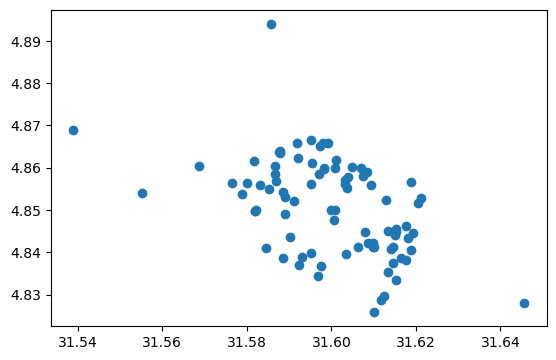

In [20]:
poi = poi.loc[poi['basic_category'] == 'hotel']
poi.plot()

## Attach destinations to graph

In [32]:
poi = gn.pandana_snap_c(
    G_largest,
    poi,
    source_crs="epsg:4326",
    target_crs=sel_wgs,
    add_dist_to_node_col=True,
)
poi.head()

,id,geometry,bbox,version,sources,names,categories,basic_category,taxonomy,confidence,websites,socials,emails,phones,brand,addresses,operating_status,NN,NN_dist
2,e1cbbc8d-cbf4-4f07-a6fe-e105e9ff9872,POINT (31.64561 4.82792),"{'xmin': 31.645612716674805, 'xmax': 31.645616...",4,"[{'property': '', 'dataset': 'meta', 'license'...","{'primary': 'Juba Highway Hotel', 'common': No...","{'primary': 'hotel', 'alternate': None}",hotel,"{'primary': 'hotel', 'hierarchy': ['lodging', ...",0.639236,[https://maps.app.goo.gl/Z8cpyo4o8VRm46C67],[https://www.facebook.com/109908188585111],None,[+211980888872],None,"[{'freeform': 'Mapaw\n', 'locality': 'Juba', '...",open,6429,79.494766
8,3110dbc7-8c77-4ada-99d5-451935c051e9,POINT (31.58569 4.89394),"{'xmin': 31.585693359375, 'xmax': 31.585697174...",4,"[{'property': '', 'dataset': 'meta', 'license'...","{'primary': 'Royal Palace Hotel', 'common': No...","{'primary': 'hotel', 'alternate': ['accommodat...",hotel,"{'primary': 'hotel', 'hierarchy': ['lodging', ...",0.639236,None,[https://www.facebook.com/1804772896486183],None,[+211922007262],None,"[{'freeform': 'KonyoKonyo ,Riverside ', 'local...",open,11375,25.991887
25,0d501d83-ad64-44c0-ad4f-1c6ee53bfe29,POINT (31.53892 4.86887),"{'xmin': 31.538917541503906, 'xmax': 31.538921...",5,"[{'property': '', 'dataset': 'meta', 'license'...","{'primary': 'Acacia Village', 'common': None, ...","{'primary': 'hotel', 'alternate': ['accommodat...",hotel,"{'primary': 'hotel', 'hierarchy': ['lodging', ...",0.950063,[https://www.acaciavillage.com/contact-page/],[https://www.facebook.com/176599229077304],None,[+211911252613],None,"[{'freeform': 'Mundri Road, Acacia Village', '...",open,9576,56.250131
56,7e3df7f4-ed47-4534-ab3a-b91e61f0f6a8,POINT (31.59233 4.83692),"{'xmin': 31.59232521057129, 'xmax': 31.5923290...",4,"[{'property': '', 'dataset': 'meta', 'license'...","{'primary': 'California Hotel Juba', 'common':...","{'primary': 'hotel', 'alternate': ['african_re...",hotel,"{'primary': 'hotel', 'hierarchy': ['lodging', ...",0.639236,None,[https://www.facebook.com/564663990261683],None,[+211954600040],None,"[{'freeform': 'ATLA BARA C, Tumbra Road ', 'lo...",open,6361,44.677828
61,05d80e96-63ef-4bd2-ad12-3cab0015f4c9,POINT (31.59311 4.83899),"{'xmin': 31.59310531616211, 'xmax': 31.5931091...",5,"[{'property': '', 'dataset': 'meta', 'license'...","{'primary': 'VIP Hotel', 'common': None, 'rule...","{'primary': 'hotel', 'alternate': ['accommodat...",hotel,"{'primary': 'hotel', 'hierarchy': ['lodging', ...",0.950063,None,[https://www.facebook.com/951485878371178],None,None,None,"[{'freeform': 'A43', 'locality': 'Juba', 'post...",open,25038,38.964508


In [41]:
# We measure travel time on the network not from POI to POI, but from graph nodes to graph nodes.
destinations = list(set(poi.NN))

#Let's measure travel time from all hotels to all other hotels
OD = gn.calculate_OD(G_largest, destinations, destinations, fail_value=9999999)

od_df = pd.DataFrame(OD/60, index=destinations, columns=destinations)
od_df.head()

,19585,10882,25475,9601,18306,23561,14090,23819,3595,25484,...,9587,9076,3060,755,7159,7032,20089,4091,252,23295
19585,0.000000,5.797190,4.340235,2.995709,7.459615,1.888106,4.805452,6.007642,4.469045,0.433360,...,6.176253,5.700196,1.552687,4.215080,5.156952,3.836712,5.415995,1.505879,8.440365,5.790282
10882,5.797190,0.000000,4.911959,8.156425,6.587217,5.650007,5.946600,3.327658,7.984706,5.905403,...,4.278953,5.987590,5.985425,3.169939,5.873367,8.699883,5.703389,6.380538,3.437298,7.201392
25475,4.340235,4.911959,0.000000,4.587960,10.113688,3.626693,7.884258,2.085464,4.141310,4.773595,...,2.216988,1.723318,3.962111,3.749515,7.811025,4.519653,1.439118,2.834356,4.518187,2.937121
9601,2.995709,8.156425,4.587960,0.000000,10.455325,4.628295,7.801162,6.271701,2.313004,3.429070,...,6.439112,4.193146,4.292877,6.250064,8.152662,1.396812,4.477347,2.128182,8.704424,3.350381
18306,7.459615,6.587217,10.113688,10.455325,0.000000,7.434357,4.875615,9.660984,11.928660,7.567829,...,10.612279,11.473649,7.769776,6.629906,3.363510,11.296327,11.189448,8.965494,9.770623,12.687451
